# Work on Healpix of CosmoDC2

- author : Sylvie Dagoret-Campagne
- Creation : January 29th 2021

In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import pyarrow
import re # to decode SED

In [3]:
# Verify SparkContext
print(sc)

# Print Spark version
print(sc.version)

<SparkContext master=mesos://vm-75063.lal.in2p3.fr:5050 appName=PySparkShell>
2.4.4


In [4]:
# Spark imports
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F

In [5]:
from pyspark.sql.functions import col, pandas_udf 
from pyspark.sql.types import LongType

from pyspark.sql.types import IntegerType,FloatType
from pyspark.sql.functions import pandas_udf, PandasUDFType

from pyspark.sql import functions as F
from pyspark.sql.functions import randn

In [6]:
# here is how we create a function ('Ang2Pix') that can be called by dataframes
# it takes as input the "ra" and "dec" values (which are not very different from theta/phi)
# and returns the pixel number (but as pandas series for efficiency)
import numpy as np
import pandas as pd
import healpy as hp

nside=512

In [7]:
! hadoop dfs -ls /lsst/DC2/cosmoDC2

DEPRECATED: Use of this script to execute hdfs command is deprecated.
Instead use the hdfs command for it.

Found 5 items
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-12-11 15:12 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image
drwxr-xr-x   - stephane.plaszczynski lsst          0 2019-10-16 10:52 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_double.parquet
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-04-23 17:28 /lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image_nofaint.parquet
drwxr-xr-x   - stephane.plaszczynski lsst          0 2020-09-07 19:17 /lsst/DC2/cosmoDC2/shear_cosmoDC2
drwxr-xr-x   - stephane.plaszczynski lsst          0 2019-04-16 18:40 /lsst/DC2/cosmoDC2/xyz_v1.1.4_hive


In [8]:
fullfilename="/lsst/DC2/cosmoDC2/cosmoDC2_v1.1.4_image"
datafile=fullfilename


In [9]:
from pyspark.sql import SparkSession

# Initialise our Spark session
spark = SparkSession.builder.getOrCreate()

In [10]:
df = spark.read.format("parquet").load(datafile)    

In [11]:
#df.printSchema()

In [12]:
list_of_columns=df.columns
#print(list_of_columns)

# Extract wavelengths

## Decode Wavelength bins

In [13]:
all_sed_columns = [ ]             # contain all names of columns with sed
all_sed_disk_columns = [ ]        # contain all names of columns with sed disk
all_sed_bulge_columns = [ ]        # contain all names of columns with sed bulge

all_sed_disk_no_host_extinction_columns = [ ]        # contain all names of columns with sed disk
all_sed_bulge_no_host_extinction_columns = [ ]        # contain all names of columns with sed bulge

all_disk = []                     # sed ending with disk
all_bulge = []                    # sed ending with bulge 
all_disk_no_host_extinction  = [] # sed ending with disk_no_host_extinction
all_bulge_no_host_extinction = [] # sed ending with disk_no_host_extinction

index=0
for x in list_of_columns:
    if re.match("^sed_*",x):
        all_sed_columns.append(x)
        
        # all_sed_disk_columns
        if re.match("^sed_.*_disk$",x):
            all_sed_disk_columns.append(x)  
        # all_sed_disk_columns
        if re.match("^sed_.*_bulge$",x):
            all_sed_bulge_columns.append(x)   
            
        # all_sed_disk_columns
        if re.match("^sed_.*_disk_no_host_extinction$",x):
            all_sed_disk_no_host_extinction_columns.append(x)  
        # all_sed_disk_columns
        if re.match("^sed_.*_bulge_no_host_extinction$",x):
            all_sed_bulge_no_host_extinction_columns.append(x)  
            
            
        # select only with _disk    
        nblist=re.findall('sed_([^ ]+)_disk$',x)
        if len(nblist)==1:
            all_disk.append(nblist[0])
        # select only with _bulge    
        nblist=re.findall('sed_([^ ]+)_bulge$',x)
        if len(nblist)==1:
            all_bulge.append(nblist[0])  
            
        # select only with _disk_no_host_extinction    
        nblist=re.findall('sed_([^ ]+)_disk_no_host_extinction$',x)
        if len(nblist)==1:
            all_disk_no_host_extinction.append(nblist[0])
        
        # select only with _bulge_no_host_extinction    
        nblist=re.findall('sed_([^ ]+)_bulge_no_host_extinction$',x)
        if len(nblist)==1:
            all_bulge_no_host_extinction.append(nblist[0])
                 
        index+=1
        


In [14]:
all_disk.sort()
all_bulge.sort()
all_disk_no_host_extinction.sort()
all_bulge_no_host_extinction.sort()

In [15]:
all_sed_disk_columns.sort()
all_sed_bulge_columns.sort()
all_sed_disk_no_host_extinction_columns.sort()
all_sed_bulge_no_host_extinction_columns.sort()

In [16]:
print(all_sed_disk_columns)

['sed_1000_246_disk', 'sed_11467_1710_disk', 'sed_1246_306_disk', 'sed_13177_1966_disk', 'sed_15143_2259_disk', 'sed_1552_381_disk', 'sed_17402_2596_disk', 'sed_1933_474_disk', 'sed_2407_591_disk', 'sed_2998_186_disk', 'sed_3184_197_disk', 'sed_3381_209_disk', 'sed_3590_222_disk', 'sed_3812_236_disk', 'sed_4048_251_disk', 'sed_4299_266_disk', 'sed_4565_283_disk', 'sed_4848_300_disk', 'sed_5148_319_disk', 'sed_5467_339_disk', 'sed_5806_360_disk', 'sed_6166_382_disk', 'sed_6548_406_disk', 'sed_6954_431_disk', 'sed_7385_458_disk', 'sed_7843_486_disk', 'sed_8329_517_disk', 'sed_8846_549_disk', 'sed_9395_583_disk', 'sed_9978_1489_disk']


In [17]:
print(all_sed_bulge_columns)

['sed_1000_246_bulge', 'sed_11467_1710_bulge', 'sed_1246_306_bulge', 'sed_13177_1966_bulge', 'sed_15143_2259_bulge', 'sed_1552_381_bulge', 'sed_17402_2596_bulge', 'sed_1933_474_bulge', 'sed_2407_591_bulge', 'sed_2998_186_bulge', 'sed_3184_197_bulge', 'sed_3381_209_bulge', 'sed_3590_222_bulge', 'sed_3812_236_bulge', 'sed_4048_251_bulge', 'sed_4299_266_bulge', 'sed_4565_283_bulge', 'sed_4848_300_bulge', 'sed_5148_319_bulge', 'sed_5467_339_bulge', 'sed_5806_360_bulge', 'sed_6166_382_bulge', 'sed_6548_406_bulge', 'sed_6954_431_bulge', 'sed_7385_458_bulge', 'sed_7843_486_bulge', 'sed_8329_517_bulge', 'sed_8846_549_bulge', 'sed_9395_583_bulge', 'sed_9978_1489_bulge']


In [18]:
print(all_sed_disk_no_host_extinction_columns)

['sed_1000_246_disk_no_host_extinction', 'sed_11467_1710_disk_no_host_extinction', 'sed_1246_306_disk_no_host_extinction', 'sed_13177_1966_disk_no_host_extinction', 'sed_15143_2259_disk_no_host_extinction', 'sed_1552_381_disk_no_host_extinction', 'sed_17402_2596_disk_no_host_extinction', 'sed_1933_474_disk_no_host_extinction', 'sed_2407_591_disk_no_host_extinction', 'sed_2998_186_disk_no_host_extinction', 'sed_3184_197_disk_no_host_extinction', 'sed_3381_209_disk_no_host_extinction', 'sed_3590_222_disk_no_host_extinction', 'sed_3812_236_disk_no_host_extinction', 'sed_4048_251_disk_no_host_extinction', 'sed_4299_266_disk_no_host_extinction', 'sed_4565_283_disk_no_host_extinction', 'sed_4848_300_disk_no_host_extinction', 'sed_5148_319_disk_no_host_extinction', 'sed_5467_339_disk_no_host_extinction', 'sed_5806_360_disk_no_host_extinction', 'sed_6166_382_disk_no_host_extinction', 'sed_6548_406_disk_no_host_extinction', 'sed_6954_431_disk_no_host_extinction', 'sed_7385_458_disk_no_host_exti

In [19]:
print(all_sed_bulge_no_host_extinction_columns)

['sed_1000_246_bulge_no_host_extinction', 'sed_11467_1710_bulge_no_host_extinction', 'sed_1246_306_bulge_no_host_extinction', 'sed_13177_1966_bulge_no_host_extinction', 'sed_15143_2259_bulge_no_host_extinction', 'sed_1552_381_bulge_no_host_extinction', 'sed_17402_2596_bulge_no_host_extinction', 'sed_1933_474_bulge_no_host_extinction', 'sed_2407_591_bulge_no_host_extinction', 'sed_2998_186_bulge_no_host_extinction', 'sed_3184_197_bulge_no_host_extinction', 'sed_3381_209_bulge_no_host_extinction', 'sed_3590_222_bulge_no_host_extinction', 'sed_3812_236_bulge_no_host_extinction', 'sed_4048_251_bulge_no_host_extinction', 'sed_4299_266_bulge_no_host_extinction', 'sed_4565_283_bulge_no_host_extinction', 'sed_4848_300_bulge_no_host_extinction', 'sed_5148_319_bulge_no_host_extinction', 'sed_5467_339_bulge_no_host_extinction', 'sed_5806_360_bulge_no_host_extinction', 'sed_6166_382_bulge_no_host_extinction', 'sed_6548_406_bulge_no_host_extinction', 'sed_6954_431_bulge_no_host_extinction', 'sed_73

In [20]:
print(all_disk)

['1000_246', '11467_1710', '1246_306', '13177_1966', '15143_2259', '1552_381', '17402_2596', '1933_474', '2407_591', '2998_186', '3184_197', '3381_209', '3590_222', '3812_236', '4048_251', '4299_266', '4565_283', '4848_300', '5148_319', '5467_339', '5806_360', '6166_382', '6548_406', '6954_431', '7385_458', '7843_486', '8329_517', '8846_549', '9395_583', '9978_1489']


In [21]:
print(all_bulge)

['1000_246', '11467_1710', '1246_306', '13177_1966', '15143_2259', '1552_381', '17402_2596', '1933_474', '2407_591', '2998_186', '3184_197', '3381_209', '3590_222', '3812_236', '4048_251', '4299_266', '4565_283', '4848_300', '5148_319', '5467_339', '5806_360', '6166_382', '6548_406', '6954_431', '7385_458', '7843_486', '8329_517', '8846_549', '9395_583', '9978_1489']


In [22]:
print(all_disk_no_host_extinction)

['1000_246', '11467_1710', '1246_306', '13177_1966', '15143_2259', '1552_381', '17402_2596', '1933_474', '2407_591', '2998_186', '3184_197', '3381_209', '3590_222', '3812_236', '4048_251', '4299_266', '4565_283', '4848_300', '5148_319', '5467_339', '5806_360', '6166_382', '6548_406', '6954_431', '7385_458', '7843_486', '8329_517', '8846_549', '9395_583', '9978_1489']


In [23]:
print(all_bulge_no_host_extinction)

['1000_246', '11467_1710', '1246_306', '13177_1966', '15143_2259', '1552_381', '17402_2596', '1933_474', '2407_591', '2998_186', '3184_197', '3381_209', '3590_222', '3812_236', '4048_251', '4299_266', '4565_283', '4848_300', '5148_319', '5467_339', '5806_360', '6166_382', '6548_406', '6954_431', '7385_458', '7843_486', '8329_517', '8846_549', '9395_583', '9978_1489']


In [24]:
def GetWavelength(wllist):
    """
    Decode wavelength from the string in list wllist
    """
    
    all_wl_aver =  []
    all_wl_width = []
    
    
    for wlstr in wllist:
        strarr= wlstr.split("_")
        
        wl=float(strarr[0])
        wdt=float(strarr[1])
        
        all_wl_aver.append(wl+wdt/2.)
        all_wl_width.append(wdt)
        
    return np.array(all_wl_aver),np.array(all_wl_width) 

In [25]:
# Decode wavelength
all_disk_wl_av , all_disk_wl_wdt = GetWavelength(all_disk)

In [26]:
NWL=len(all_disk_wl_av)

In [27]:
print(all_disk_wl_av)

[ 1123.  12322.   1399.  14160.  16272.5  1742.5 18700.   2170.   2702.5
  3091.   3282.5  3485.5  3701.   3930.   4173.5  4432.   4706.5  4998.
  5307.5  5636.5  5986.   6357.   6751.   7169.5  7614.   8086.   8587.5
  9120.5  9686.5 10722.5]


In [28]:
wl_indexes=np.argsort(all_disk_wl_av)

In [29]:
wl_indexes

array([ 0,  2,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29,  1,  3,  4,  6])

In [30]:
all_disk_wl_av[wl_indexes]

array([ 1123. ,  1399. ,  1742.5,  2170. ,  2702.5,  3091. ,  3282.5,
        3485.5,  3701. ,  3930. ,  4173.5,  4432. ,  4706.5,  4998. ,
        5307.5,  5636.5,  5986. ,  6357. ,  6751. ,  7169.5,  7614. ,
        8086. ,  8587.5,  9120.5,  9686.5, 10722.5, 12322. , 14160. ,
       16272.5, 18700. ])

In [31]:
all_disk_wl_wdt[wl_indexes]

array([ 246.,  306.,  381.,  474.,  591.,  186.,  197.,  209.,  222.,
        236.,  251.,  266.,  283.,  300.,  319.,  339.,  360.,  382.,
        406.,  431.,  458.,  486.,  517.,  549.,  583., 1489., 1710.,
       1966., 2259., 2596.])

# Good columns selection

In [32]:
selected_cols_disk = ["galaxy_id","halo_id","position_x","position_y","position_z","redshift","ra","dec"] + all_sed_disk_columns

In [33]:
selected_cols_bulge = ["galaxy_id","halo_id","position_x","position_y","position_z","redshift","ra","dec"] + all_sed_bulge_columns

In [34]:
selected_cols_disk_no_host_extinction = ["galaxy_id","halo_id","position_x","position_y","position_z","redshift","ra","dec"] + all_sed_disk_no_host_extinction_columns

In [35]:
selected_cols_bulge_no_host_extinction = ["galaxy_id","halo_id","position_x","position_y","position_z","redshift","ra","dec"] + all_sed_bulge_no_host_extinction_columns

# Select relevant dataframe

In [36]:
FLAG_LIMIT=True
NLIMIT=10000

In [37]:
if FLAG_LIMIT:

    df_small = df.limit(NLIMIT)
    rs1=df_small.select(selected_cols_disk)
    rs2=df_small.select(selected_cols_bulge)
    rs3=df_small.select(selected_cols_disk_no_host_extinction)
    rs4=df_small.select(selected_cols_bulge_no_host_extinction)
else:
    rs1=df.select(selected_cols_disk)
    rs2=df.select(selected_cols_bulge)
    rs3=df.select(selected_cols_disk_no_host_extinction)
    rs4=df.select(selected_cols_bulge_no_host_extinction)
    

In [38]:
NDATA=rs1.count()
NDATA

10000

# Search a far Galaxy

In [39]:
from pyspark.sql.functions import row_number,lit
from pyspark.sql.window import Window

In [40]:
w = Window().orderBy('galaxy_id')
rs0 = rs1.withColumn("row_num", row_number().over(w))

In [41]:
rs0.show(2)

+----------+---------+------------------+-----------------+-------------------+--------------------+-----------------+------------------+-----------------+-------------------+-----------------+-------------------+-------------------+-----------------+-------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-------+
| galaxy_id|  halo_id|        position_x|       position_y|         position_z|            redshift|               ra|               dec|sed_1000_246_disk|sed_11467_1710_disk|sed_1246_306_disk|sed_13177_1966_disk|sed_15143_2259_disk|sed_1552_381_disk|sed_17402_2596_disk|sed_1933_474_disk|sed_2407_591_dis

In [42]:
rs0.filter( (rs0.redshift  > 2.5) & (rs0.redshift  < 2.50001) ).show(3) 

+---------+-------+----------+----------+----------+--------+---+---+-----------------+-------------------+-----------------+-------------------+-------------------+-----------------+-------------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-------+
|galaxy_id|halo_id|position_x|position_y|position_z|redshift| ra|dec|sed_1000_246_disk|sed_11467_1710_disk|sed_1246_306_disk|sed_13177_1966_disk|sed_15143_2259_disk|sed_1552_381_disk|sed_17402_2596_disk|sed_1933_474_disk|sed_2407_591_disk|sed_2998_186_disk|sed_3184_197_disk|sed_3381_209_disk|sed_3590_222_disk|sed_3812_236_disk|sed_4048_251_disk|sed_4299_266_disk|sed_4565

In [43]:
#alert False

# Binning redshift

In [44]:
#histogram caracteristics
#get the minmax values in an array: you already saw how to get the output in a dataframe.
# then you can put these values in memory with the "first()" function
minmax=rs1.agg(F.min("redshift"), F.max("redshift")).head()
zmin=minmax[0]
zmax=minmax[1]
Nbins=100
dz=(zmax-zmin)/Nbins
print(zmin,zmax,dz)

0.00981945236473214 0.2497397790764435 0.002399203267117114


In [45]:
rs1=rs1.withColumn("bin", ((rs1["redshift"]-zmin)/dz).astype('int'))
#rs1.show(20)

In [46]:
# create the h dataframe using groupBy and count
h=rs1.groupBy("bin").count()
# look at some values
h.show(10)

+---+-----+
|bin|count|
+---+-----+
|  5|   15|
|  4|    2|
| 14|   29|
| 15|   18|
| 12|   11|
| 13|   29|
| 16|   11|
|  8|    3|
|  6|    6|
|  9|    5|
+---+-----+
only showing top 10 rows



In [47]:
h=h.withColumn("z", zmin+dz*h["bin"]+dz/2)

In [48]:
#sort h (see sort or orderBy in DOC)
h=h.sort("bin")
#always check some values
h.show(5)

+---+-----+--------------------+
|bin|count|                   z|
+---+-----+--------------------+
|  4|    2|0.020615867066759153|
|  5|   15| 0.02301507033387627|
|  6|    6| 0.02541427360099338|
|  8|    3| 0.03021268013522761|
|  9|    5| 0.03261188340234472|
+---+-----+--------------------+
only showing top 5 rows



In [49]:
# convert h to a pandas object (see toPandas in DOC)
# you may drop the "bin" column first (see drop in DOC)
p=h.toPandas()
print(p.columns,"size={}".format(p.index.size))

Index(['bin', 'count', 'z'], dtype='object') size=95


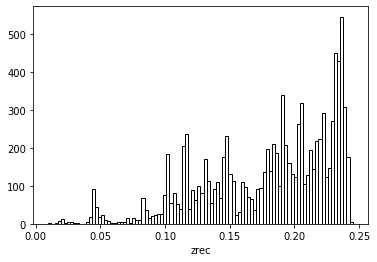

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.bar(p['z'].values,p['count'].values,dz,color='white',edgecolor='black')
plt.xlabel("zrec");

# Filter with the redshift

In [51]:
rs1_sel=rs1.filter(rs1.redshift>0.22) # filtered dataframe

In [52]:
result1_sel = rs1_sel.collect() # produce a list of rows filling the condition
type(result1_sel)

list

In [53]:
print(result1_sel[0]) # then it is easy to access to the content of the row

Row(galaxy_id=9500040900, halo_id=152401, position_x=406.1212244168134, position_y=568.858358893596, position_z=-597.2576302541813, redshift=0.22988927808659554, ra=54.47767023171588, dec=-40.51365893518041, sed_1000_246_disk=1042713.5, sed_11467_1710_disk=25867352.0, sed_1246_306_disk=1315961.875, sed_13177_1966_disk=27233678.0, sed_15143_2259_disk=30303810.0, sed_1552_381_disk=1333631.625, sed_17402_2596_disk=27138996.0, sed_1933_474_disk=1186316.875, sed_2407_591_disk=1465106.625, sed_2998_186_disk=2012014.875, sed_3184_197_disk=2294864.75, sed_3381_209_disk=2604405.5, sed_3590_222_disk=3298322.0, sed_3812_236_disk=4646397.0, sed_4048_251_disk=6164822.0, sed_4299_266_disk=7224721.5, sed_4565_283_disk=8930249.0, sed_4848_300_disk=9486058.0, sed_5148_319_disk=10505455.0, sed_5467_339_disk=12007455.0, sed_5806_360_disk=13290272.0, sed_6166_382_disk=14340342.0, sed_6548_406_disk=15652816.0, sed_6954_431_disk=16943106.0, sed_7385_458_disk=18719678.0, sed_7843_486_disk=20149828.0, sed_832

# study galaxy one by one

In [54]:
#index_gal=NDATA-1

In [55]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import desc

In [56]:
f_rs1 = rs1.withColumn("index", monotonically_increasing_id()) # add field index with the row number in creasing order
g_rs1 = f_rs1.orderBy(desc("index")).drop('index')  # decreasing order 
result1= g_rs1.take(1)

In [57]:
f_rs2 = rs2.withColumn("index", monotonically_increasing_id()) # add field index with the row number in creasing order
g_rs2 = f_rs2.orderBy(desc("index")) # decreasing order 
result2= g_rs2.take(1)

In [58]:
f_rs3 = rs3.withColumn("index", monotonically_increasing_id()) # add field index with the row number in creasing order
g_rs3 = f_rs3.orderBy(desc("index")) # decreasing order 
result3= g_rs3.take(1)

In [59]:
f_rs4 = rs4.withColumn("index", monotonically_increasing_id()) # add field index with the row number in creasing order
g_rs4 = f_rs4.orderBy(desc("index")) # decreasing order 
result4= g_rs4.take(1)

In [60]:
# get the rows
row1=result1[0]
row2=result2[0]
row3=result3[0]
row4=result4[0]

In [61]:
type(row1)

pyspark.sql.types.Row

In [62]:
row1.asDict()

{'galaxy_id': 9500043252,
 'halo_id': 163300152401,
 'position_x': 401.56318772007046,
 'position_y': 535.7365567919235,
 'position_z': -565.5625034386004,
 'redshift': 0.2174418927964754,
 'ra': 53.149142438361906,
 'dec': -40.18589358923373,
 'sed_1000_246_disk': 1634605.25,
 'sed_11467_1710_disk': 29424278.0,
 'sed_1246_306_disk': 2393745.5,
 'sed_13177_1966_disk': 30763644.0,
 'sed_15143_2259_disk': 33585284.0,
 'sed_1552_381_disk': 2568673.5,
 'sed_17402_2596_disk': 30312280.0,
 'sed_1933_474_disk': 1771772.0,
 'sed_2407_591_disk': 2500916.25,
 'sed_2998_186_disk': 3254494.5,
 'sed_3184_197_disk': 3601938.75,
 'sed_3381_209_disk': 4017079.75,
 'sed_3590_222_disk': 5016355.0,
 'sed_3812_236_disk': 7268105.5,
 'sed_4048_251_disk': 9012317.0,
 'sed_4299_266_disk': 9994028.0,
 'sed_4565_283_disk': 11765086.0,
 'sed_4848_300_disk': 12279906.0,
 'sed_5148_319_disk': 13347659.0,
 'sed_5467_339_disk': 14828170.0,
 'sed_5806_360_disk': 16165752.0,
 'sed_6166_382_disk': 17269828.0,
 'sed_65

In [63]:
row1.asDict().keys()

dict_keys(['galaxy_id', 'halo_id', 'position_x', 'position_y', 'position_z', 'redshift', 'ra', 'dec', 'sed_1000_246_disk', 'sed_11467_1710_disk', 'sed_1246_306_disk', 'sed_13177_1966_disk', 'sed_15143_2259_disk', 'sed_1552_381_disk', 'sed_17402_2596_disk', 'sed_1933_474_disk', 'sed_2407_591_disk', 'sed_2998_186_disk', 'sed_3184_197_disk', 'sed_3381_209_disk', 'sed_3590_222_disk', 'sed_3812_236_disk', 'sed_4048_251_disk', 'sed_4299_266_disk', 'sed_4565_283_disk', 'sed_4848_300_disk', 'sed_5148_319_disk', 'sed_5467_339_disk', 'sed_5806_360_disk', 'sed_6166_382_disk', 'sed_6548_406_disk', 'sed_6954_431_disk', 'sed_7385_458_disk', 'sed_7843_486_disk', 'sed_8329_517_disk', 'sed_8846_549_disk', 'sed_9395_583_disk', 'sed_9978_1489_disk', 'bin'])

In [64]:
row1.asDict().values()

dict_values([9500043252, 163300152401, 401.56318772007046, 535.7365567919235, -565.5625034386004, 0.2174418927964754, 53.149142438361906, -40.18589358923373, 1634605.25, 29424278.0, 2393745.5, 30763644.0, 33585284.0, 2568673.5, 30312280.0, 1771772.0, 2500916.25, 3254494.5, 3601938.75, 4017079.75, 5016355.0, 7268105.5, 9012317.0, 9994028.0, 11765086.0, 12279906.0, 13347659.0, 14828170.0, 16165752.0, 17269828.0, 18695248.0, 20146218.0, 22034712.0, 23459524.0, 24473956.0, 25974812.0, 26857394.0, 27965694.0, 86])

In [65]:
gal_id=row1["galaxy_id"]

In [66]:
gal_z=row1["redshift"]
gal_z

0.2174418927964754

In [67]:
def GetSEDArr(row,keylist):
    """
    From the row and a key list, return an array containing the SED
    
    """
    
    #print(row)
    thesedarr=np.zeros(NWL) # numpy array containing the SED 

    idx=0
    for mykey in keylist:
        #print(mykey," ",row[mykey])
        thesedarr[idx]=row[mykey]
        idx+=1  
        
    return thesedarr

### Get the SED

In [68]:
sed_disk=GetSEDArr(row1,all_sed_disk_columns)
sed_bulge=GetSEDArr(row2,all_sed_bulge_columns)
sed_disk_no_host_extinction=GetSEDArr(row3,all_sed_disk_no_host_extinction_columns)
sed_bulge_no_host_extinction=GetSEDArr(row4,all_sed_bulge_no_host_extinction_columns)

## Extract the X,Y for the plot

In [69]:
X=all_disk_wl_av[wl_indexes]
Y1=sed_disk[wl_indexes]/all_disk_wl_wdt[wl_indexes]    # renormilize to bin size
Y2=sed_bulge[wl_indexes]/all_disk_wl_wdt[wl_indexes]    # renormilize to bin size
Y3=sed_disk_no_host_extinction[wl_indexes]/all_disk_wl_wdt[wl_indexes]    # renormilize to bin size
Y4=sed_bulge_no_host_extinction[wl_indexes]/all_disk_wl_wdt[wl_indexes]    # renormilize to bin size

# Plot SED

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

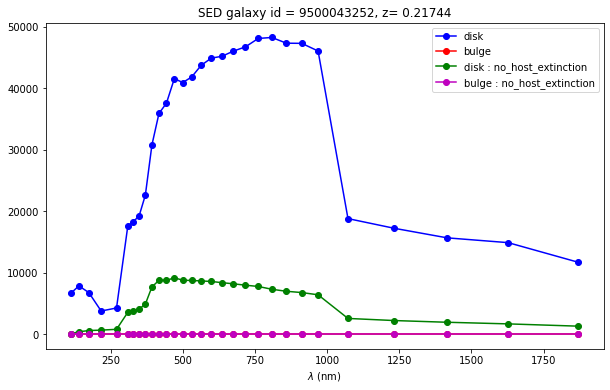

In [71]:
plt.plot(X/10,Y1,'bo-',label="disk")
plt.plot(X/10,Y2,'ro-',label="bulge")

plt.plot(X/10,Y3,'go-',label="disk : no_host_extinction")
plt.plot(X/10,Y4,'mo-',label="bulge : no_host_extinction")

title = "SED galaxy id = {}, z= {:2.5f}".format(gal_id,gal_z)
plt.xlabel("$\lambda$ (nm)")
plt.title(title)
plt.legend()